#HEART DISEASE DATASET#
##COMP0172##

In [ ]:
import os
import random


import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import os
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
from tqdm import tqdm
import wandb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout



In [ ]:
# Use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#from google.colab import files
#uploaded = files.upload()

df = pd.read_csv('/content/drive/MyDrive/heart_failure (1).csv')

#DATA ANALYSIS#

In [ ]:
# auxiliary functions
#Code taken from Lab 1 solution
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(3))
    print("##################### Tail #####################")
    print(dataframe.tail(3))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    numerical_df = dataframe.select_dtypes(include=np.number)

    print(numerical_df.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


def grab_col_names(dataframe, cat_th=10, car_th=20):

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

df.columns = [col.upper() for col in df.columns]

In [ ]:
check_df(df)

##################### Shape #####################
(918, 12)
##################### Types #####################
AGE                 int64
SEX                object
CHESTPAINTYPE      object
RESTINGBP           int64
CHOLESTEROL         int64
FASTINGBS           int64
RESTINGECG         object
MAXHR               int64
EXERCISEANGINA     object
OLDPEAK           float64
ST_SLOPE           object
HEARTDISEASE        int64
dtype: object
##################### Head #####################
   AGE SEX CHESTPAINTYPE  RESTINGBP  CHOLESTEROL  FASTINGBS RESTINGECG  MAXHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   

  EXERCISEANGINA  OLDPEAK ST_SLOPE  HEARTDISEASE  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up   

In [ ]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 918
Variables: 12
cat_cols: 7
num_cols: 5
cat_but_car: 0
num_but_cat: 2


## ANALYSIS OF THE RESPONSE VARIABLE##

              HEARTDISEASE      Ratio
HEARTDISEASE                         
1                      508  55.337691
0                      410  44.662309
##########################################


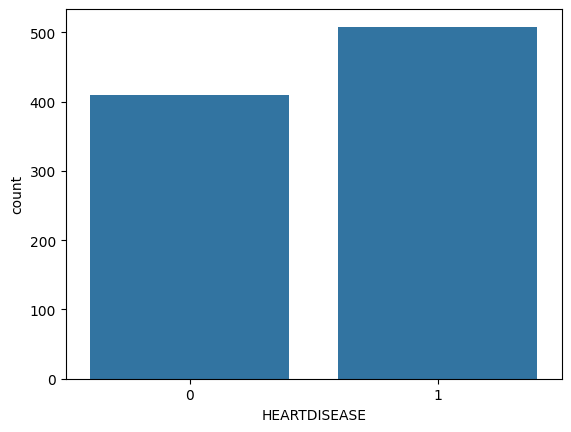

In [ ]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()


cat_summary(df, "HEARTDISEASE",plot=True)

#balanced

The response variable looks fairly well-balanced

##ANALYSIS OF EXPLANATORY VARIABLES##
###PLOTS OF DISTRIBUTIONS OF EACH VARIABLE###

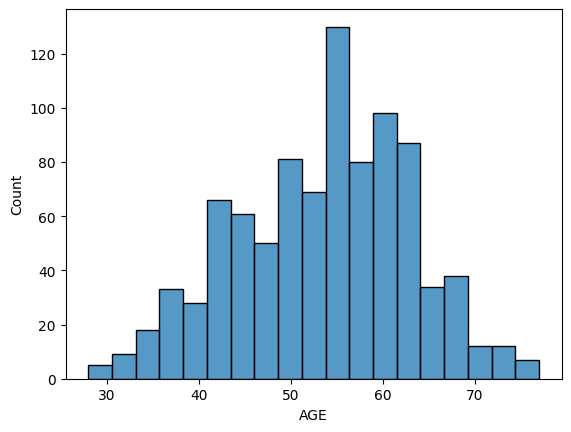

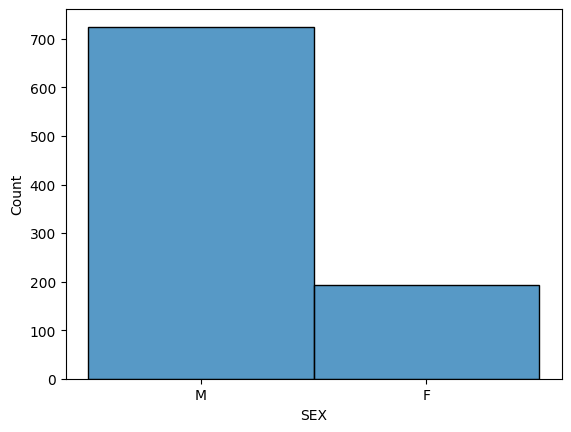

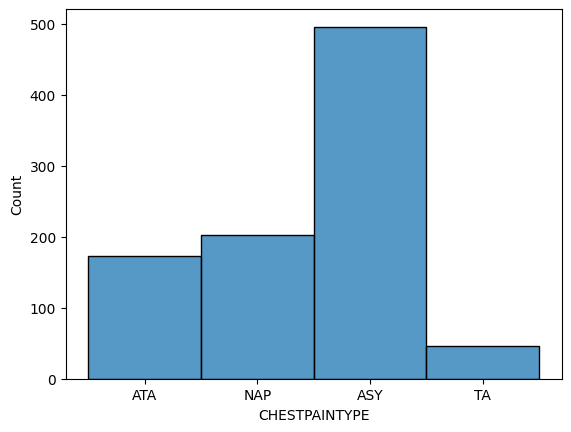

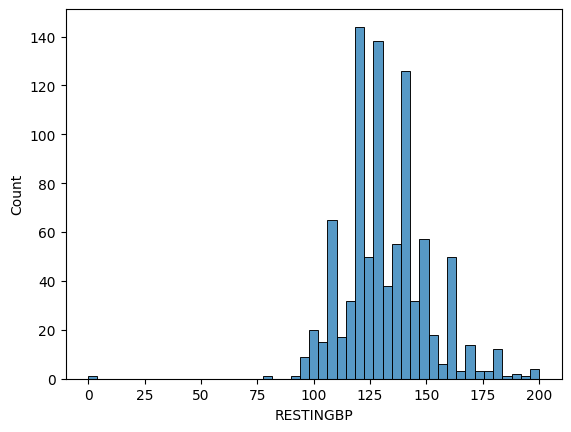

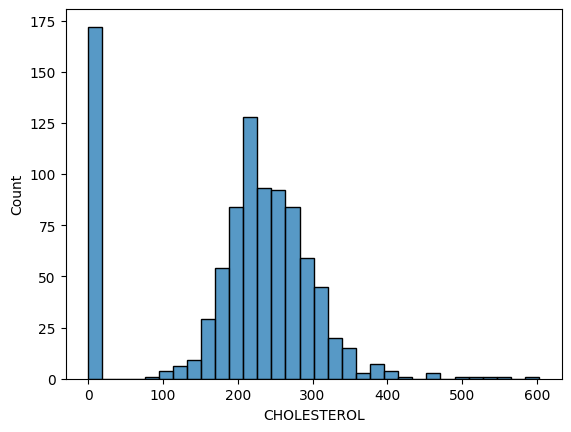

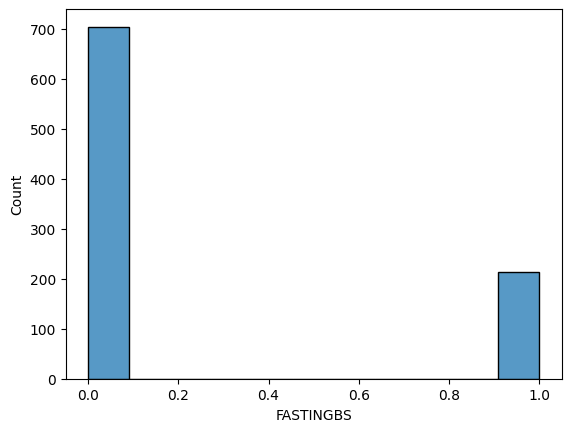

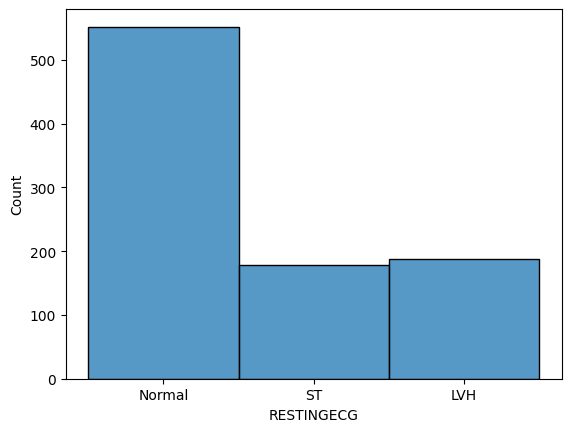

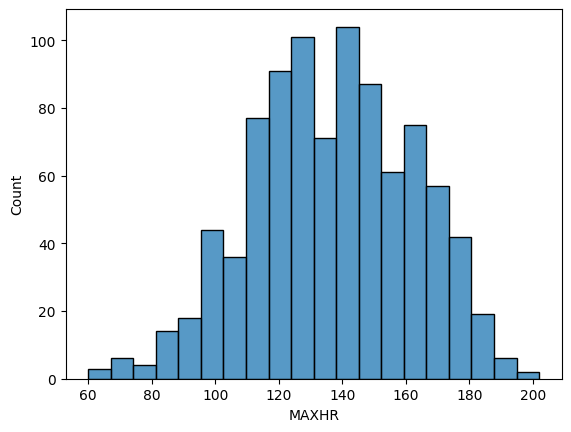

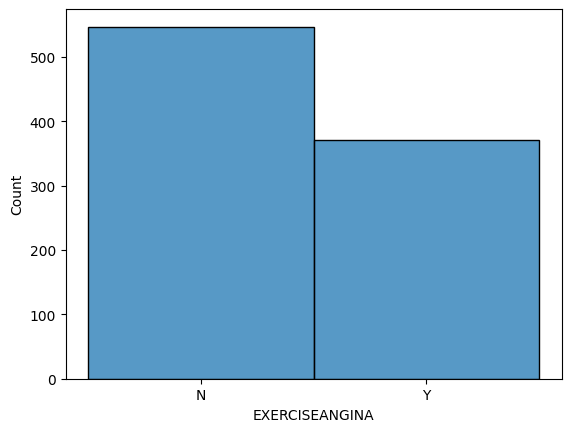

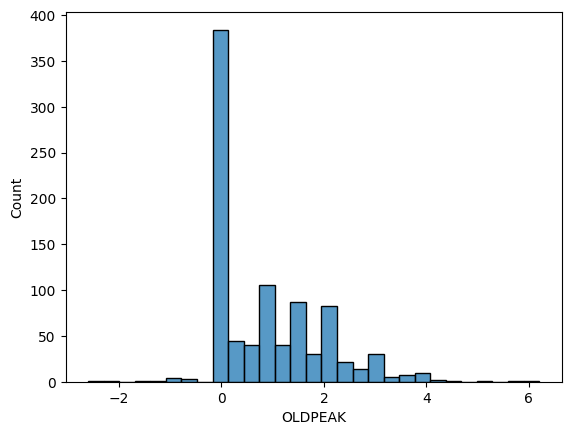

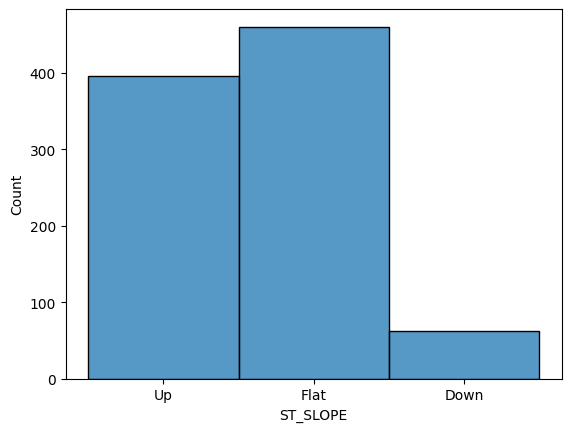

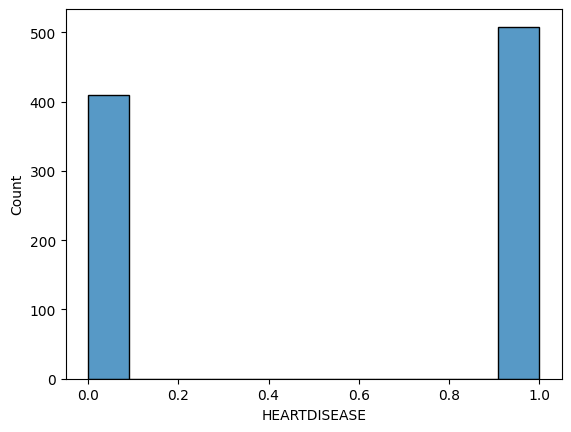

In [ ]:
for col in df.columns:

  sns.histplot(data=df, x=col)
  plt.show()


###CORRELATION MATRIX FOR NUMERICAL VARIABLES###

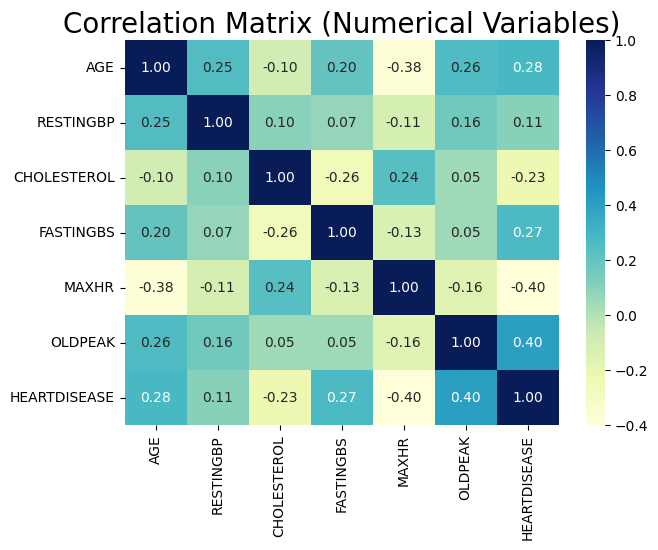

In [ ]:
#first get numerical columns
num_cols = [col for col in df.columns if df[col].dtypes != "O"]

# Calculate correlation matrix for numerical columns only
corr_matrix = df[num_cols].corr()

f, ax = plt.subplots(figsize=[7, 5])
sns.heatmap(corr_matrix, annot=True, fmt=".2f", ax=ax, cmap="YlGnBu")
ax.set_title("Correlation Matrix (Numerical Variables)", fontsize=20)
plt.show()

# Result: Weak correlations between numerical variables
# No strong correlations between explanatory variables so no need to remove them

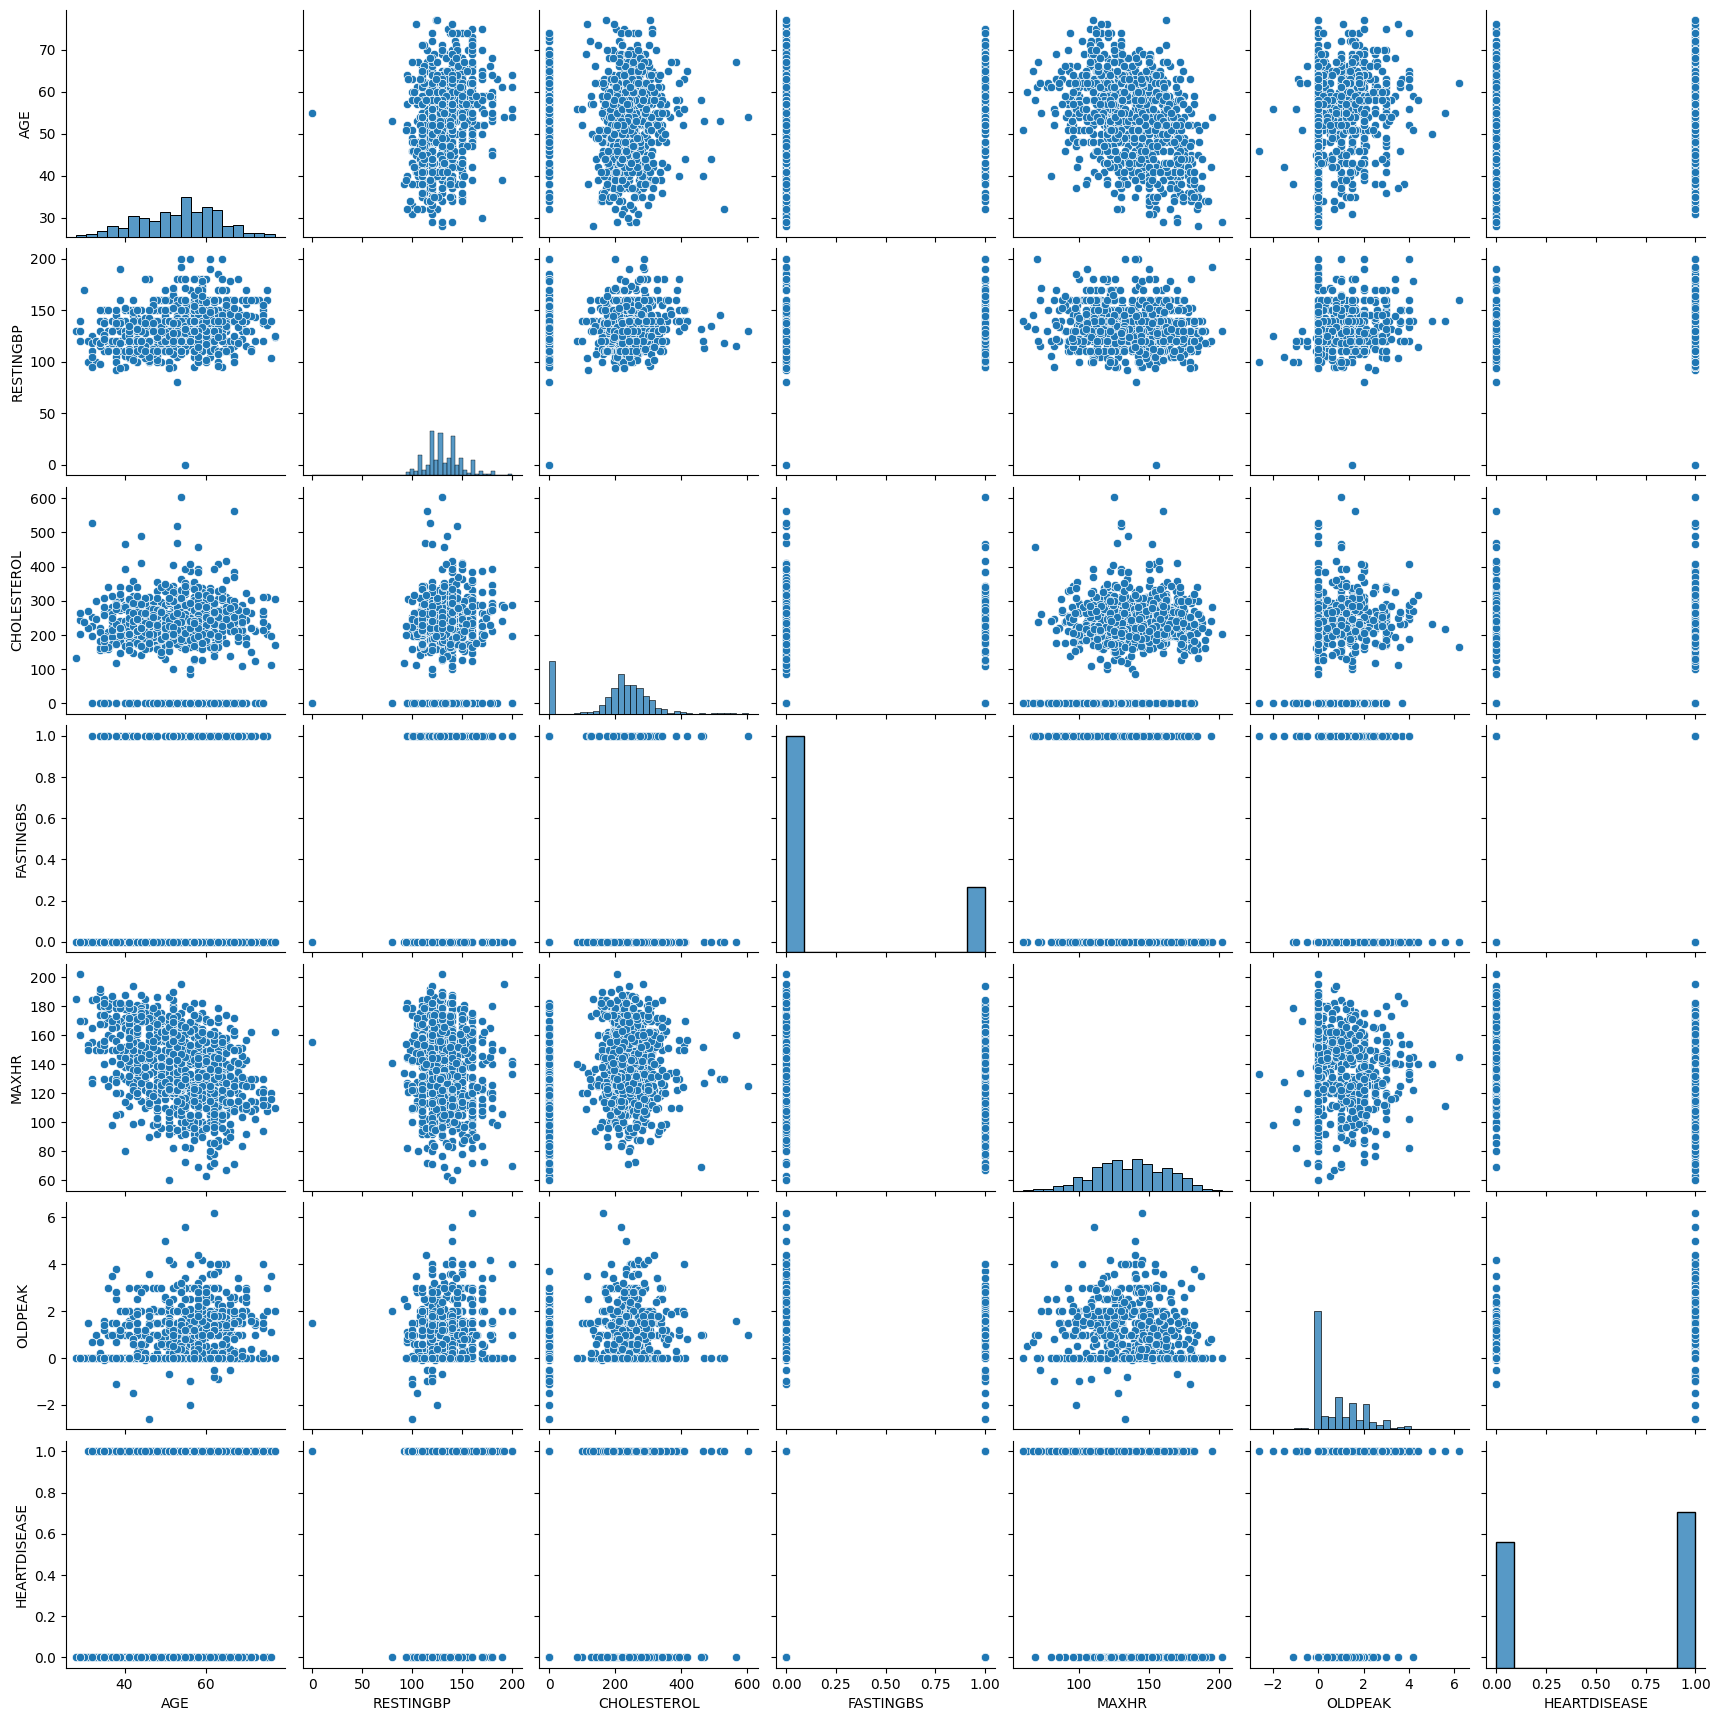

In [ ]:
# pairplot
sns.pairplot(df)

###CHECK HOW EXPLANATORY VARIABLES CORRELATE WITH THE RESPONSE VARIABLE###

####NUMERICAL VARIABLES####

In [ ]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

target_summary_with_num(df,"HEARTDISEASE","RESTINGBP")
target_summary_with_num(df,"HEARTDISEASE","CHOLESTEROL")
target_summary_with_num(df,"HEARTDISEASE","AGE")
target_summary_with_num(df,"HEARTDISEASE","MAXHR")
target_summary_with_num(df,"HEARTDISEASE","OLDPEAK")

               RESTINGBP
HEARTDISEASE            
0             130.180488
1             134.185039


              CHOLESTEROL
HEARTDISEASE             
0              227.121951
1              175.940945


                    AGE
HEARTDISEASE           
0             50.551220
1             55.899606


                   MAXHR
HEARTDISEASE            
0             148.151220
1             127.655512


               OLDPEAK
HEARTDISEASE          
0             0.408049
1             1.274213




<Axes: xlabel='HEARTDISEASE', ylabel='OLDPEAK'>

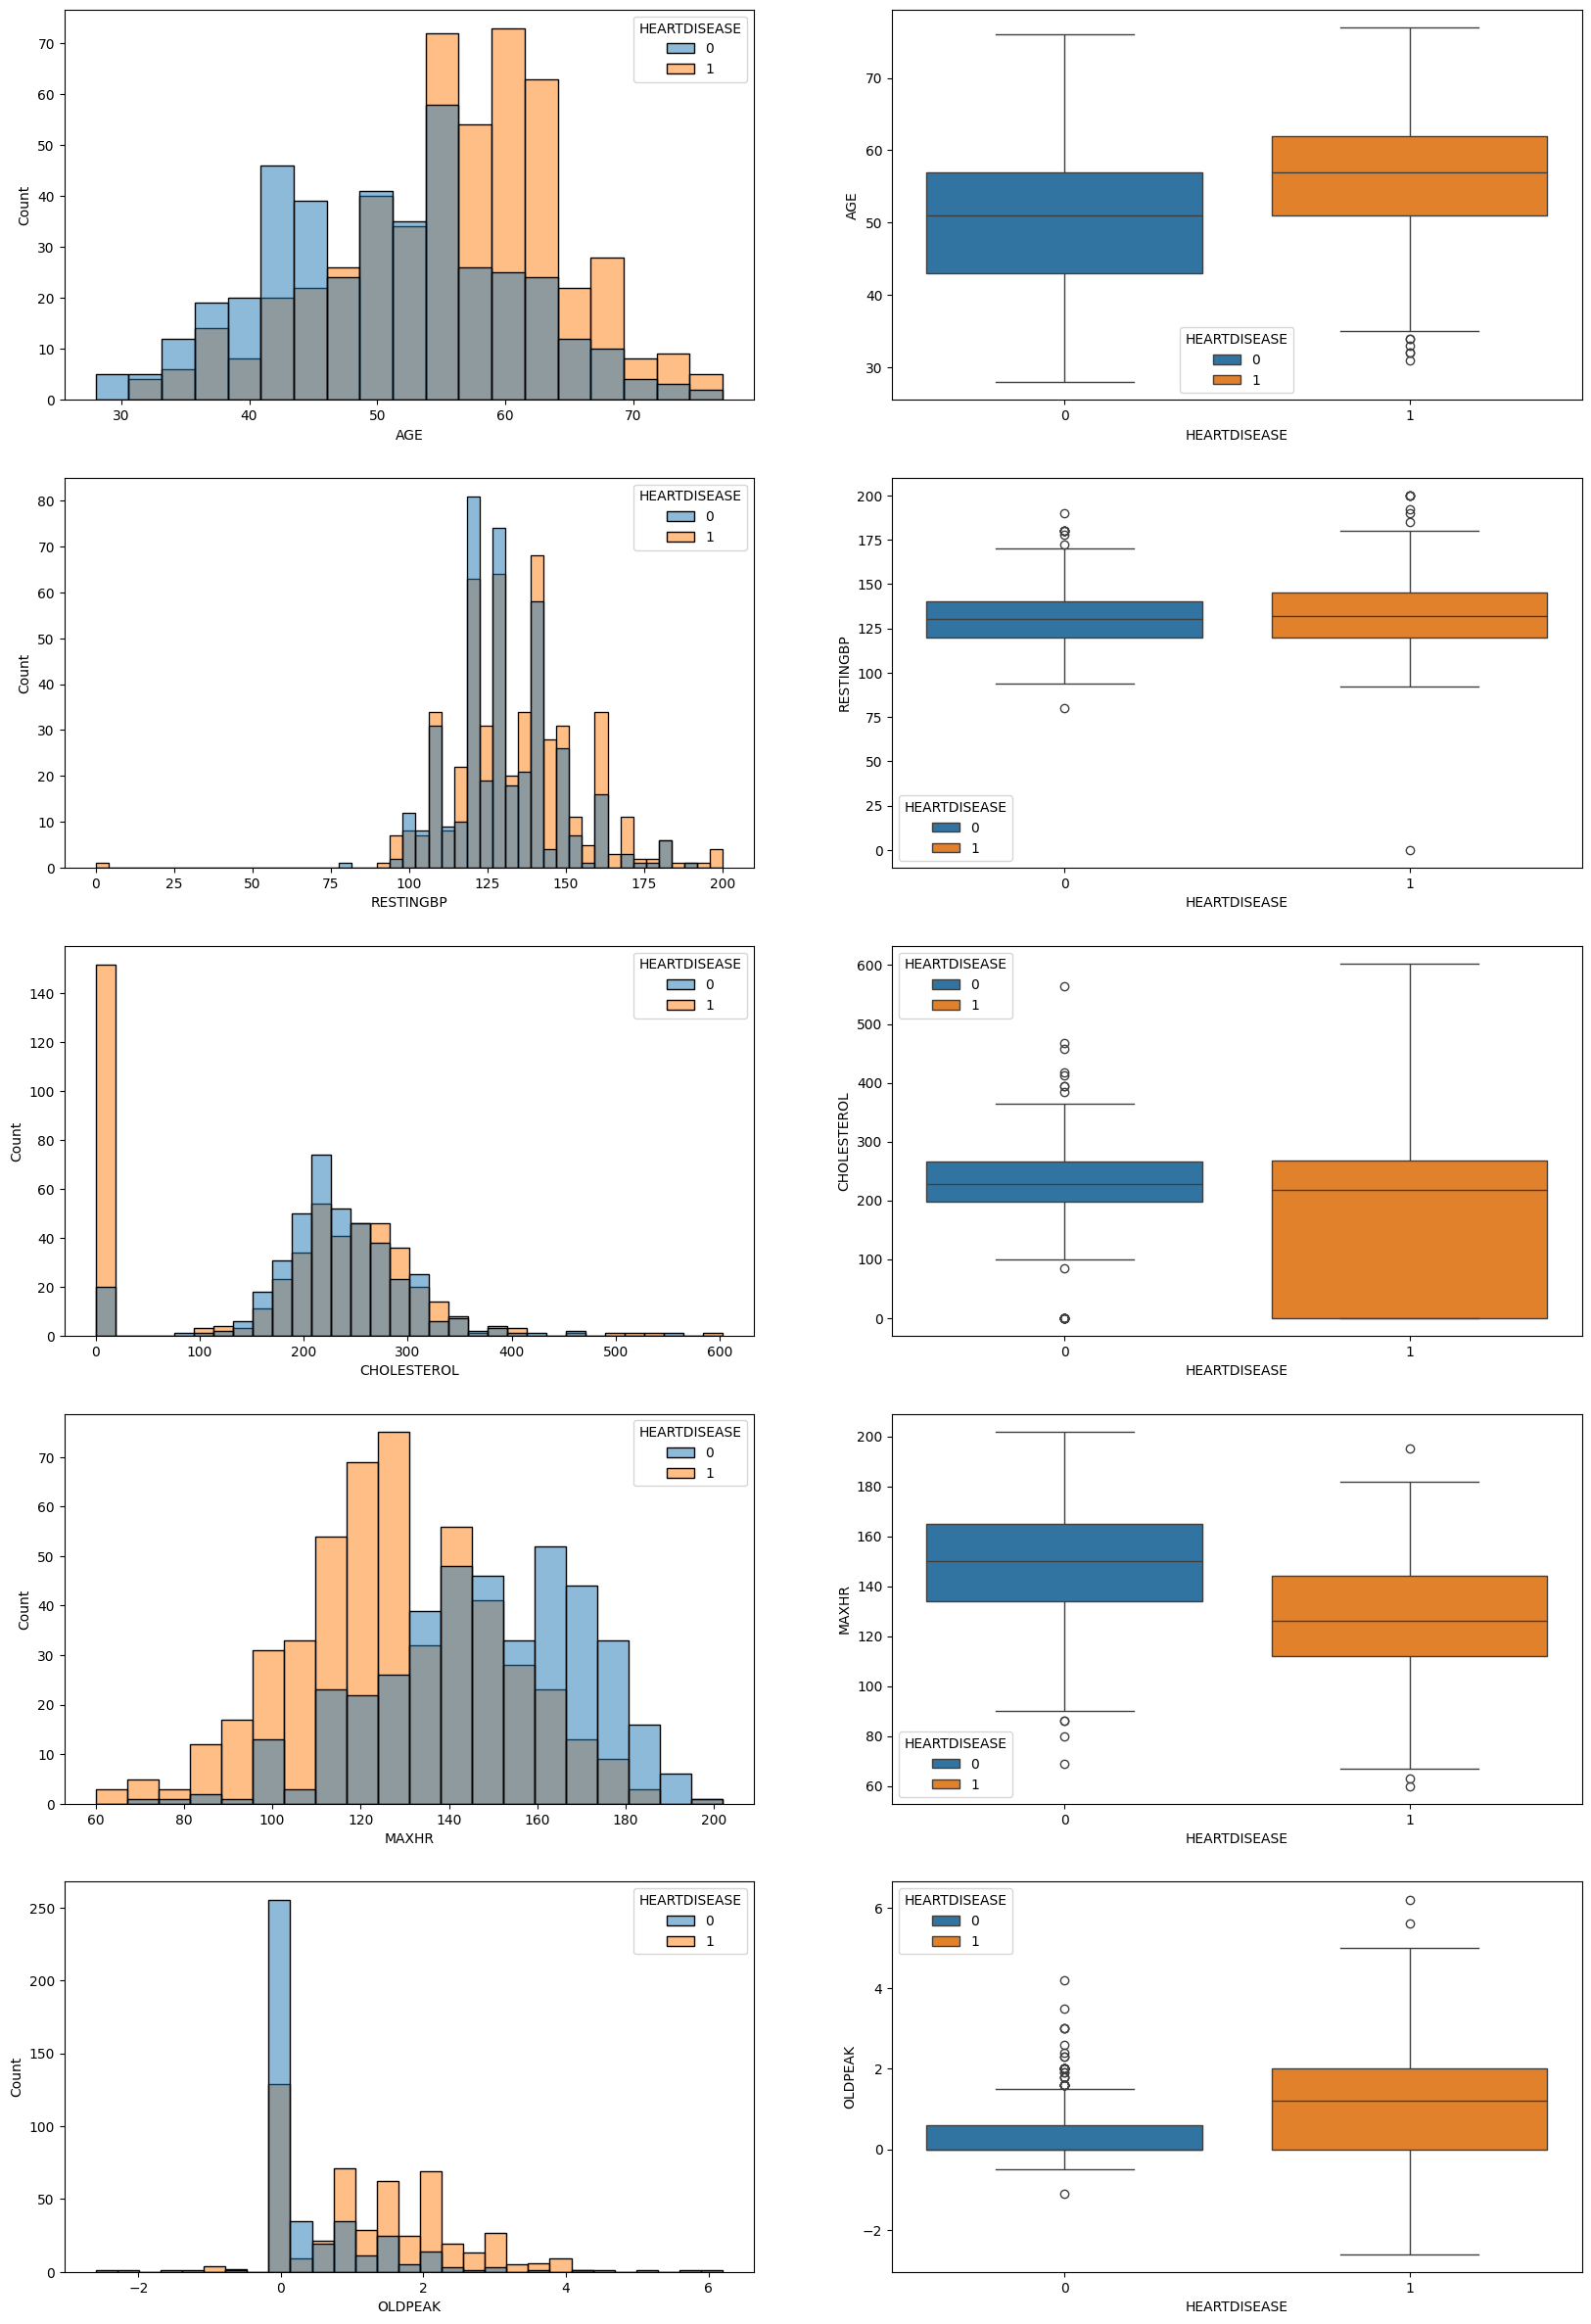

In [ ]:

fig, axes = plt.subplots(5, 2, figsize = (20, 30))

sns.histplot(ax = axes[0, 0], x = 'AGE', hue = 'HEARTDISEASE', fill = True, data = df)
sns.boxplot(ax = axes[0, 1], x = 'HEARTDISEASE', y = 'AGE', hue = 'HEARTDISEASE', data = df)

sns.histplot(ax = axes[1, 0], x = 'RESTINGBP', hue = 'HEARTDISEASE', fill = True, data = df)
sns.boxplot(ax = axes[1, 1], x = 'HEARTDISEASE', y = 'RESTINGBP', hue = 'HEARTDISEASE', data = df)

sns.histplot(ax = axes[2,0], x = 'CHOLESTEROL', hue = 'HEARTDISEASE', fill = True, data = df)
sns.boxplot(ax = axes[2,1], x = 'HEARTDISEASE', y = 'CHOLESTEROL', hue = 'HEARTDISEASE', data = df)

sns.histplot(ax = axes[3,0], x = 'MAXHR', hue = 'HEARTDISEASE', fill = True, data = df)
sns.boxplot(ax = axes[3,1], x = 'HEARTDISEASE', y = 'MAXHR', hue = 'HEARTDISEASE', data = df)

sns.histplot(ax = axes[4,0], x = 'OLDPEAK', hue = 'HEARTDISEASE', fill = True, data = df)
sns.boxplot(ax = axes[4,1], x = 'HEARTDISEASE', y = 'OLDPEAK', hue = 'HEARTDISEASE', data = df)

####CATEGORICAL VARIABLES####

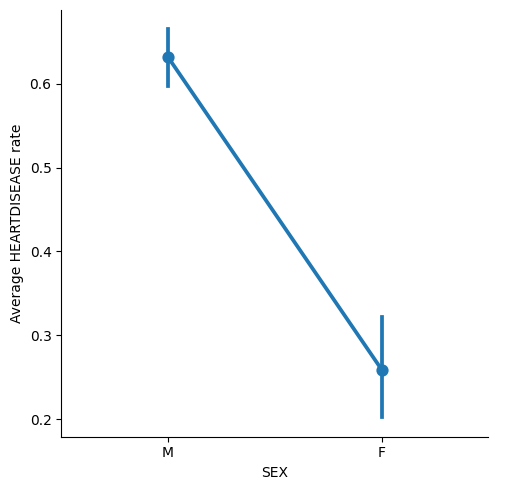

In [ ]:
#plot relationship between response and explanatory
plot1 = sns.catplot(data = df, x = 'SEX', y = 'HEARTDISEASE', kind = 'point')
plot1.set_xlabels('SEX')
plot1.set_ylabels('Average HEARTDISEASE rate')



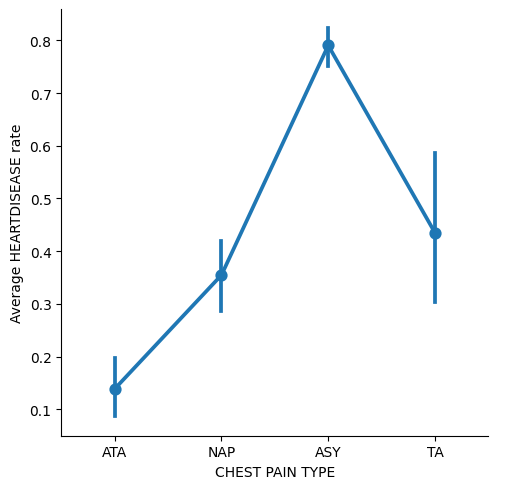

In [ ]:
plot1 = sns.catplot(data = df, x = 'CHESTPAINTYPE', y = 'HEARTDISEASE', kind = 'point')
plot1.set_xlabels('CHEST PAIN TYPE')
plot1.set_ylabels('Average HEARTDISEASE rate')

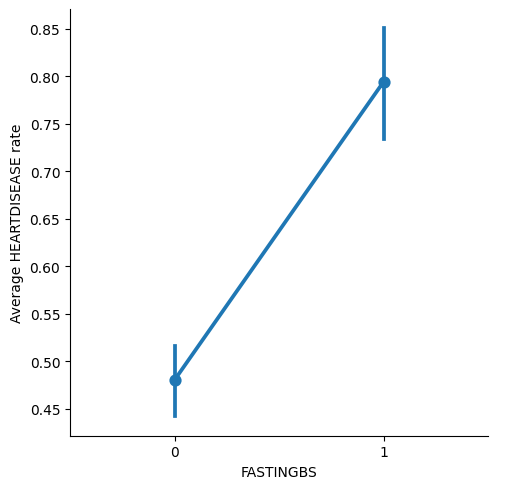

In [ ]:
# Plot relationship between categorical variables and HD
plot1 = sns.catplot(data = df, x = 'FASTINGBS', y = 'HEARTDISEASE', kind = 'point')
plot1.set_xlabels('FASTINGBS')
plot1.set_ylabels('Average HEARTDISEASE rate')

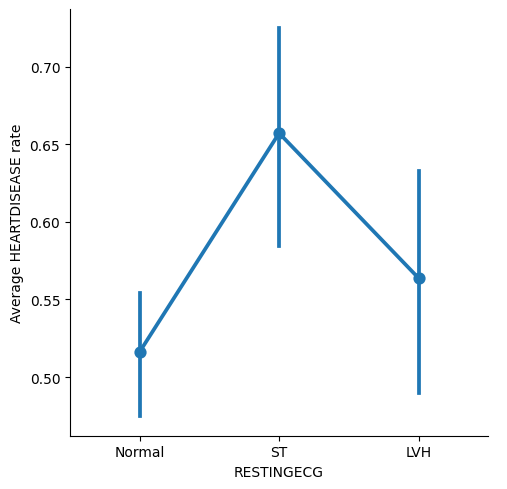

In [ ]:
plot1 = sns.catplot(data = df, x = 'RESTINGECG', y = 'HEARTDISEASE', kind = 'point')
plot1.set_xlabels('RESTINGECG')
plot1.set_ylabels('Average HEARTDISEASE rate')

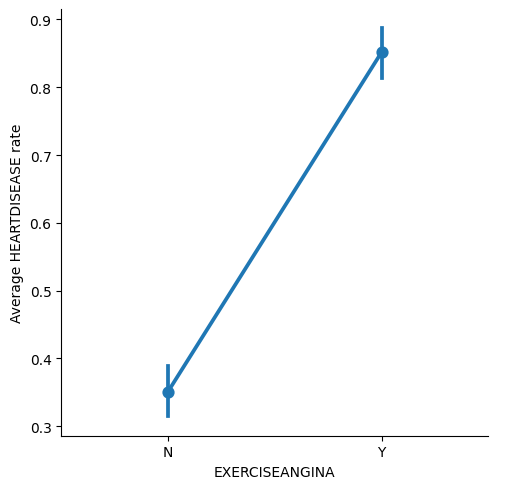

In [ ]:
plot1 = sns.catplot(data = df, x = 'EXERCISEANGINA', y = 'HEARTDISEASE', kind = 'point')
plot1.set_xlabels('EXERCISEANGINA')
plot1.set_ylabels('Average HEARTDISEASE rate')

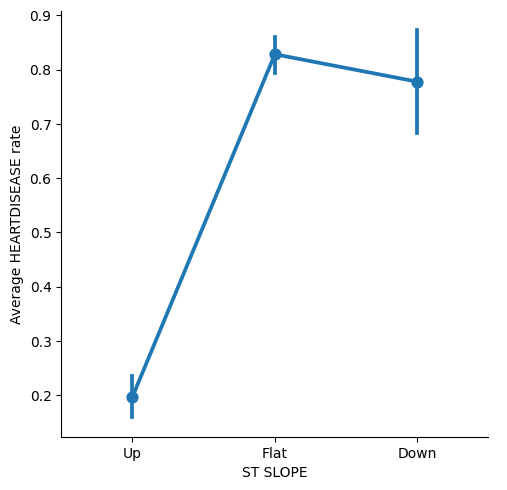

In [ ]:
plot1 = sns.catplot(data = df, x = 'ST_SLOPE', y = 'HEARTDISEASE', kind = 'point')
plot1.set_xlabels('ST SLOPE')
plot1.set_ylabels('Average HEARTDISEASE rate')

####PLOT RELATIONSHIP BETWEEN NUMERICAL AND CATEGORICAL EXPLANATORY VARIABLES####

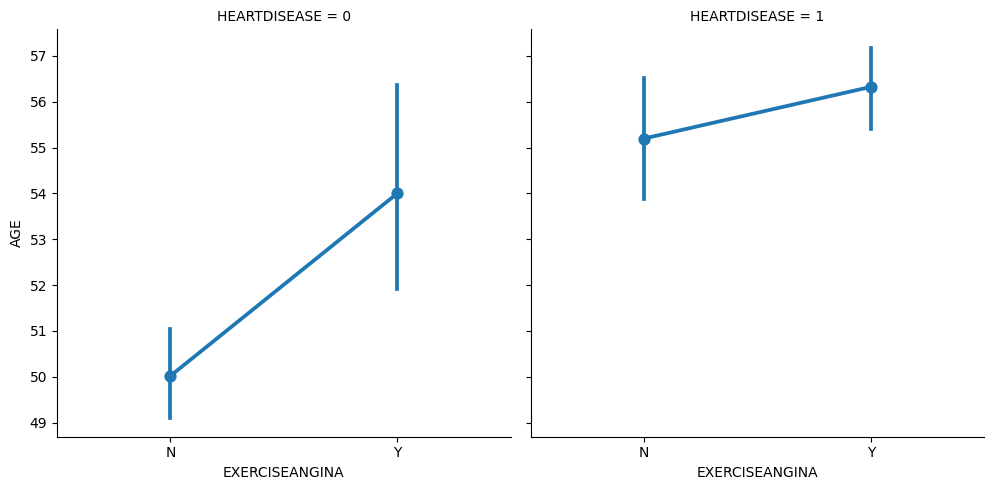

In [ ]:
# ANALYSIS OF RELATIONSHIPS BETWEEN EXPLANATORY VARIABLES
sns.catplot(data = df, x = 'EXERCISEANGINA', y = 'AGE', col = 'HEARTDISEASE', kind = 'point');

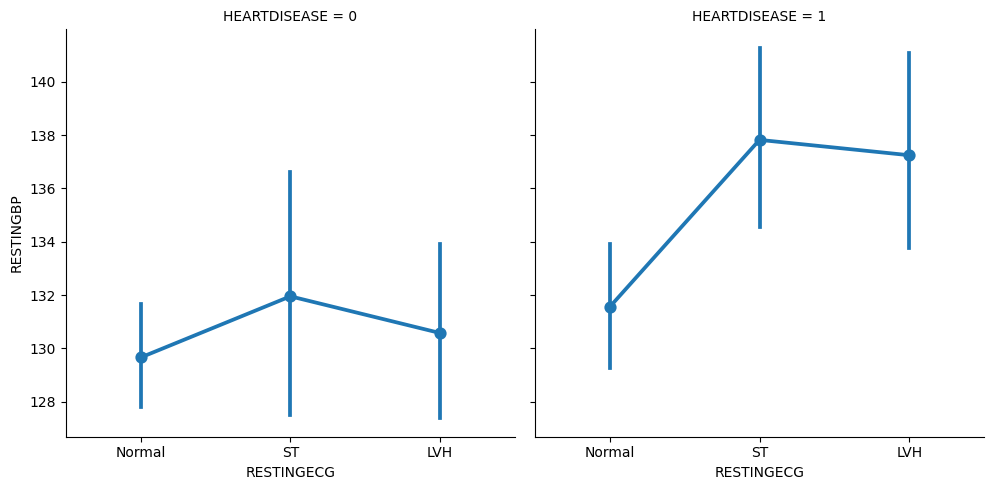

In [ ]:
sns.catplot(data = df, y = 'RESTINGBP', x = 'RESTINGECG', col = 'HEARTDISEASE', kind = 'point');

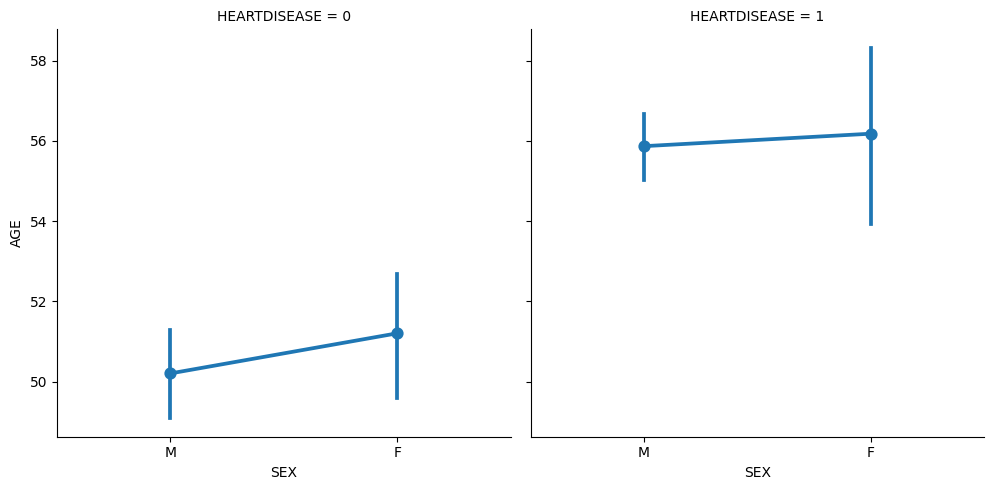

In [ ]:
sns.catplot(data = df, y = 'AGE', x = 'SEX', col = 'HEARTDISEASE', kind = 'point');

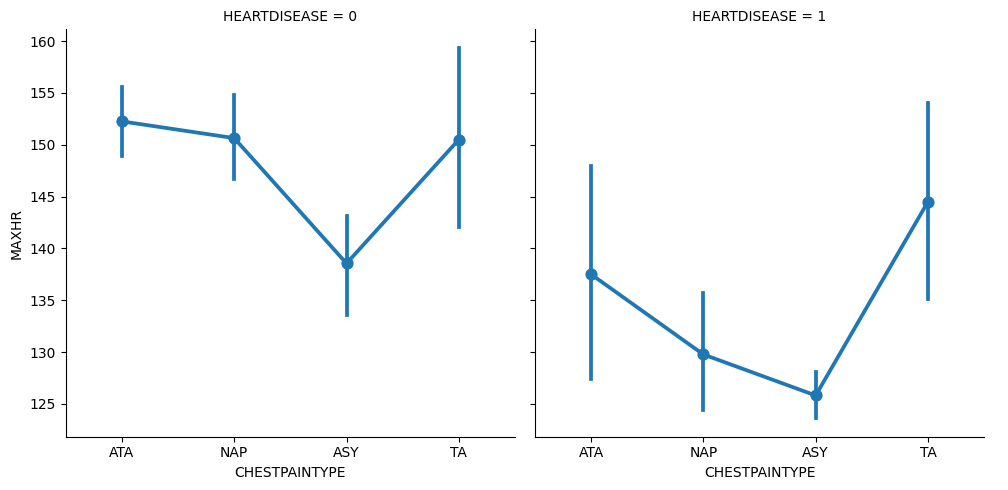

In [ ]:
sns.catplot(data = df, x = 'CHESTPAINTYPE', y = 'MAXHR', col = 'HEARTDISEASE', kind = 'point');

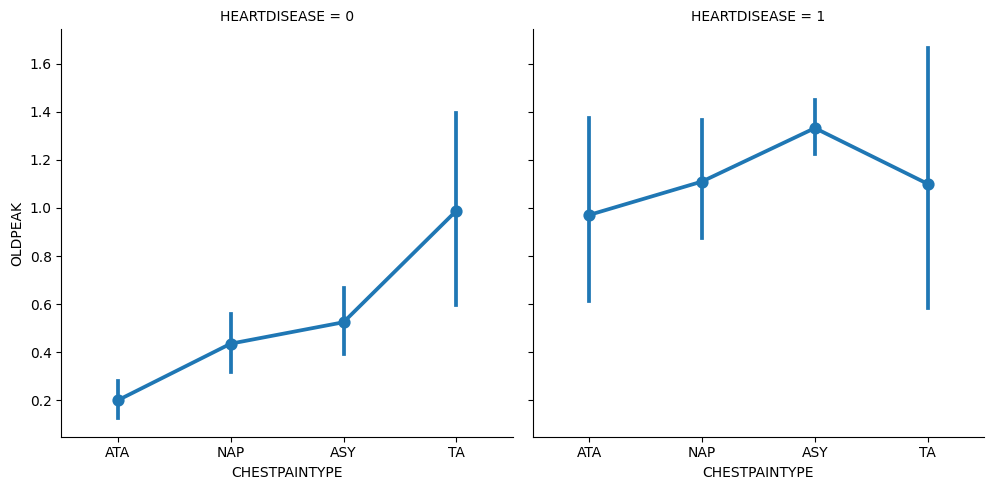

In [ ]:
sns.catplot(data = df, y = 'OLDPEAK', x = 'CHESTPAINTYPE', col = 'HEARTDISEASE', kind = 'point');

#### CHECK MISSING VALUES####

In [ ]:
## missing value
#missing value analysis
df.isna().sum()


,0
AGE,0
SEX,0
CHESTPAINTYPE,0
RESTINGBP,0
CHOLESTEROL,0
FASTINGBS,0
RESTINGECG,0
MAXHR,0
EXERCISEANGINA,0
OLDPEAK,0


#### CHECK NONSENSICAL VALUES ####

In [ ]:
print((df==0).sum())

AGE                 0
SEX                 0
CHESTPAINTYPE       0
RESTINGBP           1
CHOLESTEROL       172
FASTINGBS         704
RESTINGECG          0
MAXHR               0
EXERCISEANGINA      0
OLDPEAK           368
ST_SLOPE            0
HEARTDISEASE      410
dtype: int64


In [ ]:
df[["CHOLESTEROL", "RESTINGBP"]]= df[["CHOLESTEROL", "RESTINGBP"]].replace(0,np.NaN)

### ENCODING###

In [ ]:
#label encoding
le = LabelEncoder()
df['SEX'] = le.fit_transform(df['SEX'])
print(le.classes_)

['F' 'M']


In [ ]:

df['EXERCISEANGINA'] = le.fit_transform(df['EXERCISEANGINA'])
print(le.classes_)

['N' 'Y']


In [ ]:
# One-hot encoding
df = pd.concat([df, pd.get_dummies(df['CHESTPAINTYPE'])], axis=1)

df = df.drop('CHESTPAINTYPE', axis=1)

In [ ]:
df = pd.concat([df, pd.get_dummies(df['RESTINGECG'])], axis=1)

df = df.drop('RESTINGECG', axis=1)

In [ ]:
df = pd.concat([df, pd.get_dummies(df['ST_SLOPE'])], axis=1)

df = df.drop('ST_SLOPE', axis=1)

In [ ]:
print(df)

     AGE  SEX  RESTINGBP  CHOLESTEROL  FASTINGBS  MAXHR  EXERCISEANGINA  \
0     40    1      140.0        289.0          0    172               0   
1     49    0      160.0        180.0          0    156               0   
2     37    1      130.0        283.0          0     98               0   
3     48    0      138.0        214.0          0    108               1   
4     54    1      150.0        195.0          0    122               0   
..   ...  ...        ...          ...        ...    ...             ...   
913   45    1      110.0        264.0          0    132               0   
914   68    1      144.0        193.0          1    141               0   
915   57    1      130.0        131.0          0    115               1   
916   57    0      130.0        236.0          0    174               0   
917   38    1      138.0        175.0          0    173               0   

     OLDPEAK  HEARTDISEASE    ASY    ATA    NAP     TA    LVH  Normal     ST  \
0        0.0       

In [ ]:
#Convert True/False to 0/1

df[['ASY', 'ATA', 'NAP', 'TA', 'LVH', 'Normal', 'ST', 'Down', 'Flat', 'Up']] = df[['ASY', 'ATA', 'NAP', 'TA', 'LVH', 'Normal', 'ST', 'Down', 'Flat', 'Up']].astype(int)




In [ ]:
print(df)

     AGE  SEX  RESTINGBP  CHOLESTEROL  FASTINGBS  MAXHR  EXERCISEANGINA  \
0     40    1      140.0        289.0          0    172               0   
1     49    0      160.0        180.0          0    156               0   
2     37    1      130.0        283.0          0     98               0   
3     48    0      138.0        214.0          0    108               1   
4     54    1      150.0        195.0          0    122               0   
..   ...  ...        ...          ...        ...    ...             ...   
913   45    1      110.0        264.0          0    132               0   
914   68    1      144.0        193.0          1    141               0   
915   57    1      130.0        131.0          0    115               1   
916   57    0      130.0        236.0          0    174               0   
917   38    1      138.0        175.0          0    173               0   

     OLDPEAK  HEARTDISEASE  ASY  ATA  NAP  TA  LVH  Normal  ST  Down  Flat  Up  
0        0.0      

##SPLITTING THE DATA##

In [ ]:

y = df["HEARTDISEASE"]

X = df.drop(["HEARTDISEASE"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y,
 test_size=0.2, random_state=42)



print("Training set size: ", len(X_train))
print("Test set size: ",len(X_test))

Training set size:  734
Test set size:  184


In [ ]:
#Impute missing  values in training AND test set. Remember we set 0 cholesterol to NaN
#first check
print("TRAINING SET")
X_train.isna().sum()

TRAINING SET


,0
AGE,0
SEX,0
RESTINGBP,1
CHOLESTEROL,137
FASTINGBS,0
MAXHR,0
EXERCISEANGINA,0
OLDPEAK,0
ASY,0
ATA,0


In [ ]:
print("Test SET")
X_test.isna().sum()

Test SET


,0
AGE,0
SEX,0
RESTINGBP,0
CHOLESTEROL,35
FASTINGBS,0
MAXHR,0
EXERCISEANGINA,0
OLDPEAK,0
ASY,0
ATA,0


###IMPUTATION FOR THE NONSENSICAL VALUES###

In [ ]:
# Missing value imputation for cholesterol
no_hd_median = X_train[y_train == 0]['CHOLESTEROL'].median()
hd_median = X_train[y_train == 1]['CHOLESTEROL'].median()

X_train.loc[(y_train == 0) & (X_train['CHOLESTEROL'].isna()), 'CHOLESTEROL'] = no_hd_median
X_train.loc[(y_train == 1) & (X_train['CHOLESTEROL'].isna()), 'CHOLESTEROL'] = hd_median


X_test.loc[(y_test == 0) & (X_test['CHOLESTEROL'].isna()), 'CHOLESTEROL'] = no_hd_median
X_test.loc[(y_test== 1) & (X_test['CHOLESTEROL'].isna()), 'CHOLESTEROL'] = hd_median

In [ ]:
# Missing value imputation for restingbp
no_hd_median = X_train[y_train == 0]['RESTINGBP'].median()
hd_median = X_train[y_train == 1]['RESTINGBP'].median()

X_train.loc[(y_train == 0) & (X_train['RESTINGBP'].isna()), 'RESTINGBP'] = no_hd_median
X_train.loc[(y_train == 1) & (X_train['RESTINGBP'].isna()), 'RESTINGBP'] = hd_median

###SCALING###

In [ ]:
#Apply standard scaling to the numerical variables

scaler = StandardScaler()

# Fit the scaler on the training data for age, restingbp, cholesterol and maxhr
scaler.fit(X_train[['AGE', 'RESTINGBP', 'CHOLESTEROL', 'MAXHR']])

# Transform the training and test sets
X_train[['AGE', 'RESTINGBP', 'CHOLESTEROL', 'MAXHR']] = scaler.transform(X_train[['AGE', 'RESTINGBP', 'CHOLESTEROL', 'MAXHR']])
X_test[['AGE', 'RESTINGBP', 'CHOLESTEROL', 'MAXHR']] = scaler.transform(X_test[['AGE', 'RESTINGBP', 'CHOLESTEROL', 'MAXHR']])

#MODELLING AND PREDICTIONS#

##MODEL 1: LOGISTIC REGRESSION##

In [ ]:
# fit model
lr_model = LogisticRegression(random_state=46).fit(X_train, y_train)

#make predictions
y_training_pred = lr_model.predict(X_train)
y_pred = lr_model.predict(X_test)

#get accuracy on sets
print("Training accuracy: ", accuracy_score(y_training_pred, y_train))
print("Test accuracy: ", accuracy_score(y_pred, y_test))

# print a classification report
logistic_report = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))

#store evaluation metrics
logistic_accuracy = logistic_report['accuracy']
logistic_precision = logistic_report['weighted avg']['precision']
logistic_recall = logistic_report['weighted avg']['recall']
logistic_f1 = logistic_report['weighted avg']['f1-score']

Training accuracy:  0.8651226158038147
Test accuracy:  0.8695652173913043
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        77
           1       0.91      0.86      0.88       107

    accuracy                           0.87       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.87      0.87       184



In [ ]:
print(logistic_accuracy)
print(logistic_precision)
print(logistic_recall)
print(logistic_f1)

0.8695652173913043
0.8725526298046252
0.8695652173913043
0.8701295986622073


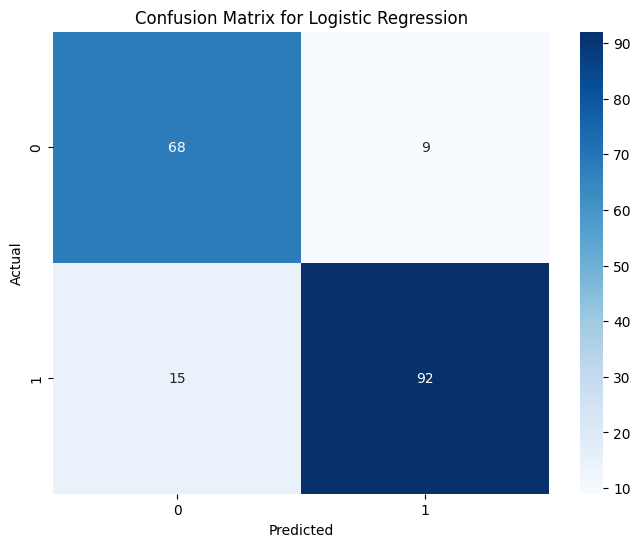

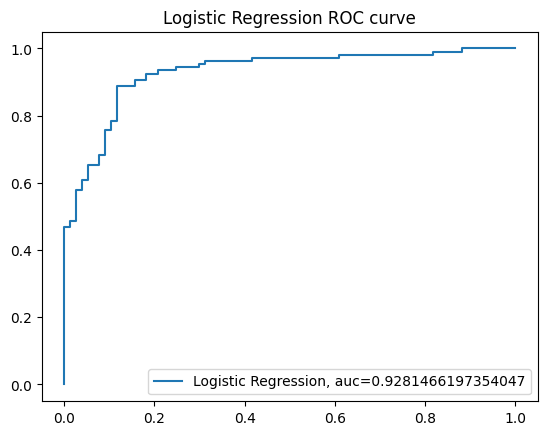

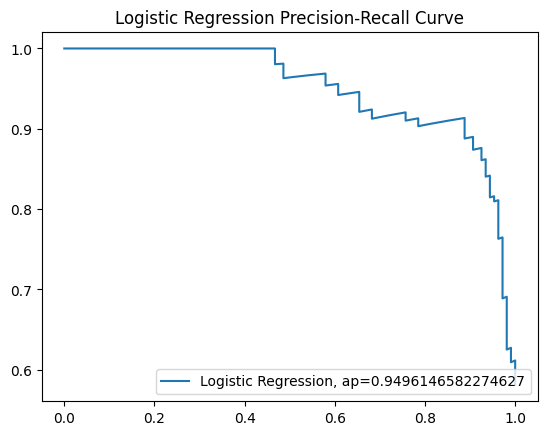

In [ ]:
#GRAPHS

#confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

# ROC curve
probs = lr_model.predict_proba(X_test) #first need predictions as probabilities
y_pred_proba = probs[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="Logistic Regression, auc="+str(auc))
plt.title('Logistic Regression ROC curve')
plt.legend(loc=4)
plt.show()

# Preicion recall curve
precision, recall, thresholds = precision_recall_curve(y_test,  y_pred_proba)
ap=metrics.average_precision_score(y_test, y_pred_proba)
plt.plot(recall,precision,label="Logistic Regression, ap="+str(ap))
plt.title('Logistic Regression Precision-Recall Curve')
plt.legend(loc=4)
plt.show()

# store evaluation values
logisitc_auc = auc
logistic_ap = ap

In [ ]:
# Model coefficients
coefficients = lr_model.coef_[0]
feature_names = X_train.columns

for coef, feature in zip(coefficients, feature_names):
    print(f"{feature}: {coef}")

AGE: 0.15864324596688584
SEX: 1.3478381178250198
RESTINGBP: 0.005528087956813521
CHOLESTEROL: 0.05466089774896523
FASTINGBS: 1.106910776472702
MAXHR: -0.21654267777477504
EXERCISEANGINA: 0.9626743517297491
OLDPEAK: 0.4204634415202981
ASY: 1.0217480012339726
ATA: -0.541702445788165
NAP: -0.3365433077327673
TA: -0.14063784539564342
LVH: 0.03524952820931667
Normal: 0.05448795408169382
ST: -0.08687307997361314
Down: 0.02636167573218775
Flat: 1.1176586487077682
Up: -1.1411559221225531


##MODEL 2: RANDOM FOREST CLASSIFIER##

Training accuracy:  1.0
Test accuracy:  0.9021739130434783
              precision    recall  f1-score   support

           0       0.86      0.91      0.89        77
           1       0.93      0.90      0.91       107

    accuracy                           0.90       184
   macro avg       0.90      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184

[0 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 0 1 1 0 1 1 0 0 1 1 0 1 0 0 1 0 1 1 1 0 1
 0 1 1 1 1 1 0 0 1 1 1 1 0 0 0 1 1 0 0 0 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0 1 1
 0 1 0 1 0 1 1 1 1 0 1 1 0 1 0 0 0 1 1 0 0 0 1 0 1 1 0 1 1 0 1 1 0 0 1 0 1
 1 0 0 1 0 1 0 1 0 1 1 0 1 0 0 0 1 0 1 0 1 1 0 1 0 1 1 0 1 0 0 1 1 1 1 1 0
 0 0 0 1 1 0 1 0 0 0 0 1 0 0 1 0 1 1 1 1 0 0 1 1 0 1 0 1 0 1 0 1 1 1 0 1]


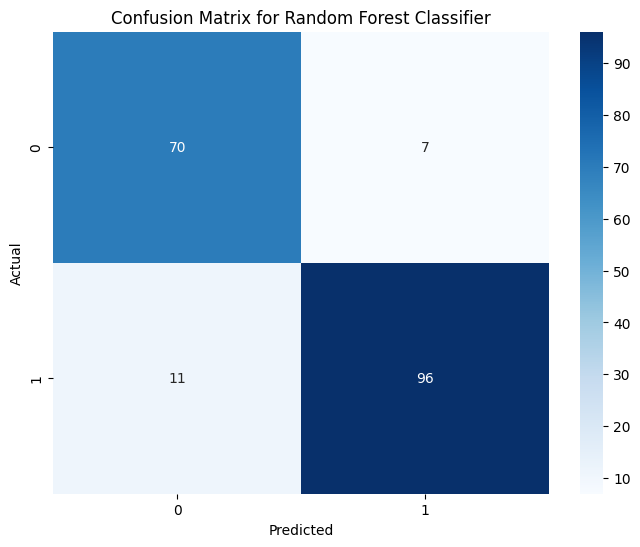

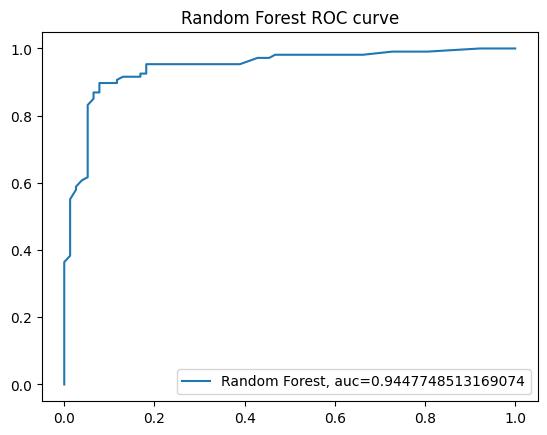

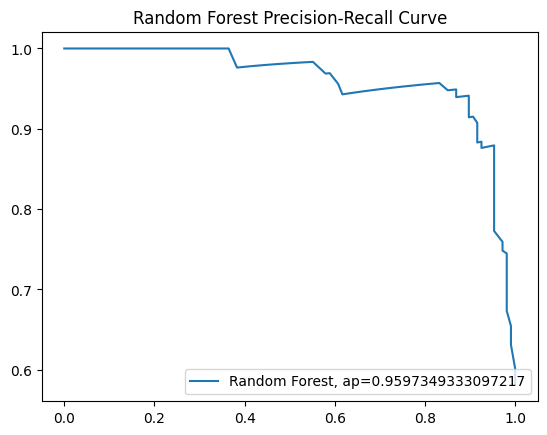

In [ ]:
# fit model
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)

#predict
y_training_pred = rf_model.predict(X_train)
y_pred = rf_model.predict(X_test)

#accuracy
print("Training accuracy: ", accuracy_score(y_training_pred, y_train))
print("Test accuracy: ", accuracy_score(y_pred, y_test))

#classification report
rf_report = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))

# store evaluation metrics
rf_accuracy = rf_report['accuracy']
rf_precision = rf_report['weighted avg']['precision']
rf_recall = rf_report['weighted avg']['recall']
rf_f1 = rf_report['weighted avg']['f1-score']
print(y_pred)

#Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()

# ROC curve
probs = rf_model.predict_proba(X_test)
y_pred_proba = probs[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="Random Forest, auc="+str(auc))
plt.title('Random Forest ROC curve')
plt.legend(loc=4)
plt.show()

#Precision recall curve
precision, recall, thresholds = precision_recall_curve(y_test,  y_pred_proba)
ap=metrics.average_precision_score(y_test, y_pred_proba)
plt.plot(recall,precision,label="Random Forest, ap="+str(ap))
plt.title('Random Forest Precision-Recall Curve')
plt.legend(loc=4)
plt.show()

# store evaluation metrics
rf_auc = auc
rf_ap = ap

In [ ]:
# print data where the model gets it wrong
misclassified_indices = np.where(y_pred != y_test)[0]
misclassified_data = X_test.iloc[misclassified_indices]
print(misclassified_data)

          AGE  SEX  RESTINGBP  CHOLESTEROL  FASTINGBS     MAXHR  \
773  0.250993    1  -0.745952    -1.032039          0  1.020130   
768  1.105885    0  -0.182854     1.147323          0 -0.560148   
39  -0.603898    0   0.943343    -0.358418          0 -0.244093   
655 -1.458790    1   1.055963    -0.437667          0  1.770762   
679  0.999024    1   0.661794    -0.239544          1  0.546047   
826 -0.283314    1  -0.464403    -0.001795          1  1.178158   
759  0.037270    1   3.308357     0.751075          0  2.323860   
650 -0.603898    1  -0.182854     0.216141          1  0.546047   
375  2.067639    0   1.506442    -0.011701          0 -0.599655   
334 -0.283314    1  -0.182854    -0.011701          1  1.336186   
662 -1.031344    1  -1.309051    -0.952789          0  1.612735   
294 -2.313682    1  -2.153698    -0.011701          1 -0.362614   
652  0.571578    1   1.506442     0.552952          0 -0.441628   
314 -0.069591    1  -2.998346    -0.219731          0  0.19048

In [ ]:
#Accuracy per class

#Sex
female_accuracy =1 - len(misclassified_data[(misclassified_data['SEX'] == 0)])/len(X_test[X_test['SEX']==0])
print("Female accuracy: ", round(female_accuracy,3))
male_accuracy =1 - len(misclassified_data[(misclassified_data['SEX'] == 1)])/len(X_test[X_test['SEX']==1])
print("Male accuracy: ",round(male_accuracy,3))

#FastingBP
fbp0_accuracy =1 - len(misclassified_data[(misclassified_data['FASTINGBS'] == 0)])/len(X_test[X_test['FASTINGBS']==0])
print("FastingBP 0 accuracy: ", round(fbp0_accuracy,3))
fbp1_accuracy =1 - len(misclassified_data[(misclassified_data['FASTINGBS'] == 1)])/len(X_test[X_test['FASTINGBS']==1])
print("FastingBP 1 accuracy: ",round(fbp1_accuracy,3))

#Exercise Angina
ea0_accuracy =1 - len(misclassified_data[(misclassified_data['EXERCISEANGINA'] == 0)])/len(X_test[X_test['EXERCISEANGINA']==0])
print("EA 0 accuracy: ", round(ea0_accuracy,3))
ea1_accuracy =1 - len(misclassified_data[(misclassified_data['EXERCISEANGINA'] == 1)])/len(X_test[X_test['EXERCISEANGINA']==1])
print("EA 1 accuracy: ",round(ea1_accuracy,3))

#I could do this using a for loop instead...

Female accuracy:  0.852
Male accuracy:  0.911
FastingBP 0 accuracy:  0.912
FastingBP 1 accuracy:  0.872
EA 0 accuracy:  0.879
EA 1 accuracy:  0.941


In [ ]:
def calculate_class_accuracy(df, y_true, y_pred, categorical_column):

  class_accuracies = {}
  for class_value in df[categorical_column].unique():
    class_data = df[df[categorical_column] == class_value]
    class_true_labels = y_true[df[categorical_column] == class_value]
    class_pred_labels = y_pred[df[categorical_column] == class_value]
    class_accuracy = accuracy_score(class_true_labels, class_pred_labels)
    class_accuracies[class_value] = class_accuracy

  return class_accuracies

categorical_columns = ['SEX', 'FASTINGBS', 'EXERCISEANGINA', 'ASY', 'ATA', 'NAP', 'TA', 'LVH','Normal', 'ST', 'Down','Flat', 'Up']

for column in categorical_columns:
  class_accuracies = calculate_class_accuracy(X_test, y_test, y_pred, column)
  print(f"Accuracies for {column}:")
  for class_value, accuracy in class_accuracies.items():
    print(f"  {class_value}: {accuracy:.3f}")




Accuracies for SEX:
  0: 0.852
  1: 0.911
Accuracies for FASTINGBS:
  0: 0.912
  1: 0.872
Accuracies for EXERCISEANGINA:
  0: 0.879
  1: 0.941
Accuracies for ASY:
  0: 0.910
  1: 0.895
Accuracies for ATA:
  1: 0.971
  0: 0.887
Accuracies for NAP:
  0: 0.895
  1: 0.927
Accuracies for TA:
  0: 0.918
  1: 0.714
Accuracies for LVH:
  0: 0.931
  1: 0.795
Accuracies for Normal:
  1: 0.926
  0: 0.868
Accuracies for ST:
  0: 0.891
  1: 0.946
Accuracies for Down:
  0: 0.905
  1: 0.867
Accuracies for Flat:
  0: 0.874
  1: 0.938
Accuracies for Up:
  1: 0.875
  0: 0.927


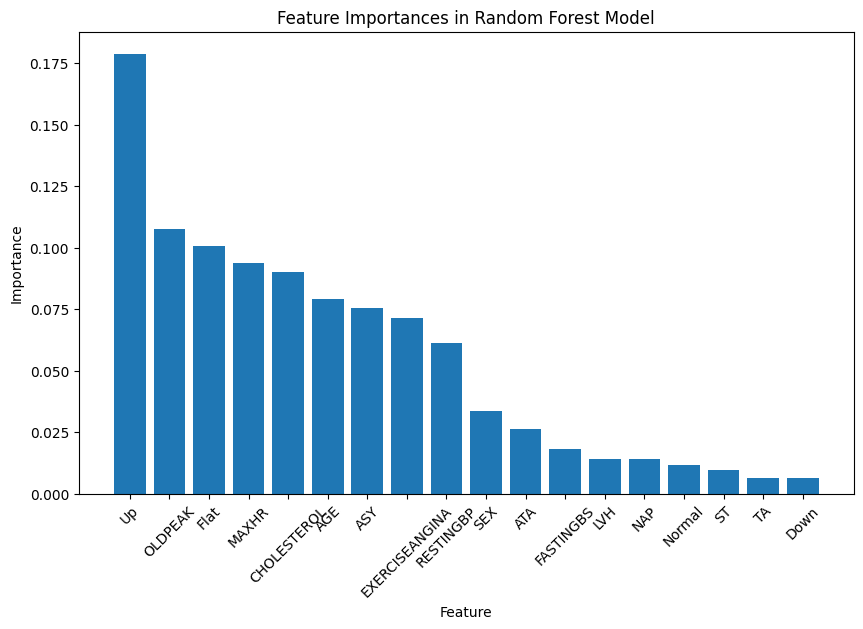

In [ ]:
# The code below plots feature importances
importances = rf_model.feature_importances_  # Get feature importances
indices = np.argsort(importances)[::-1]  # Sort importances in descending order
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=45)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances in Random Forest Model')
plt.show()



##MODEL 3: XGBOOST##

Training accuracy:  1.0
Test accuracy:  0.8695652173913043
              precision    recall  f1-score   support

           0       0.84      0.86      0.85        77
           1       0.90      0.88      0.89       107

    accuracy                           0.87       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.87      0.87       184

[0 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 0 1 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 1 1 1
 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 0 0 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0 1 1
 0 1 0 1 0 1 1 1 1 0 1 1 0 1 0 0 0 1 1 0 1 0 1 0 1 1 0 1 1 0 1 1 0 1 1 0 1
 1 0 0 1 0 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 0 1 0 0 1 1 1 1 1 0
 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 1 1 1 0 0 1 1 0 1 0 1 1 1 0 1 1 1 0 1]


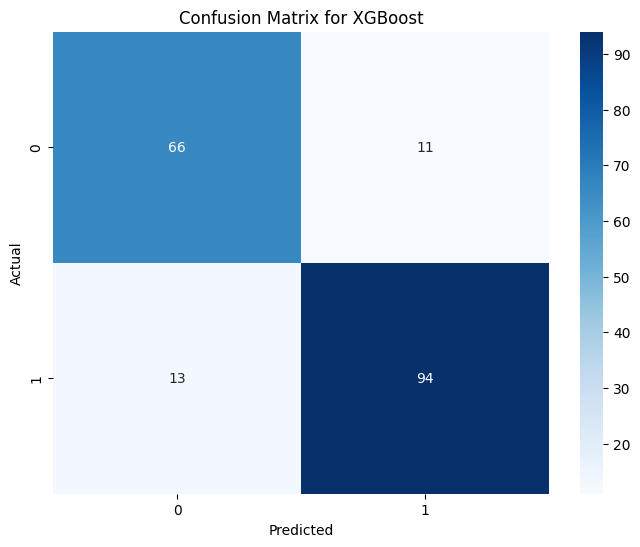

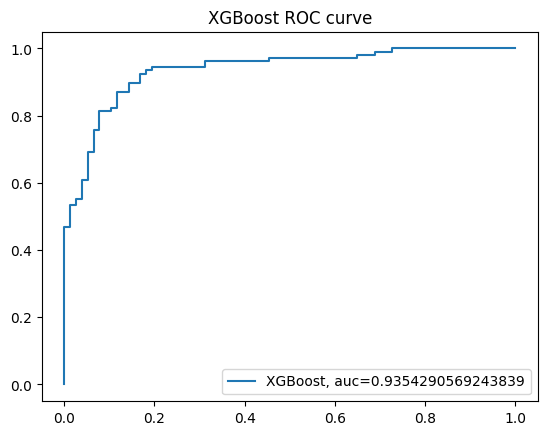

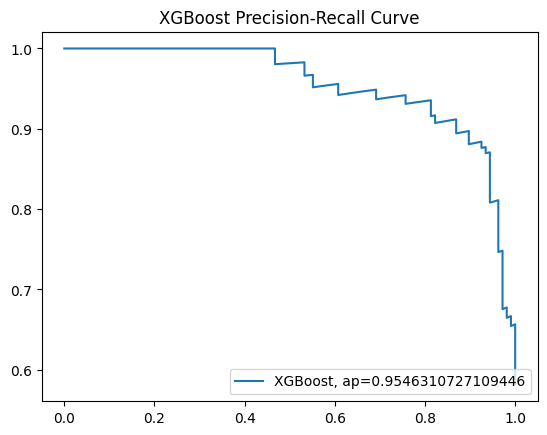

In [ ]:

# fit model
model = xgb.XGBClassifier()

model.fit(X_train, y_train)

# make predictions
y_training_pred = model.predict(X_train)
y_pred = model.predict(X_test)

# accuracy
print("Training accuracy: ", accuracy_score(y_training_pred, y_train))
print("Test accuracy: ", accuracy_score(y_pred, y_test))

# classification report
xg_report = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))

#store eval metrics
xg_accuracy = xg_report['accuracy']
xg_precision = xg_report['weighted avg']['precision']
xg_recall = xg_report['weighted avg']['recall']
xg_f1 = xg_report['weighted avg']['f1-score']
print(y_pred)

#confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for XGBoost')
plt.show()


#roc
probs = model.predict_proba(X_test)
y_pred_proba = probs[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="XGBoost, auc="+str(auc))
plt.title('XGBoost ROC curve')
plt.legend(loc=4)
plt.show()

#precision recall
precision, recall, thresholds = precision_recall_curve(y_test,  y_pred_proba)
ap=metrics.average_precision_score(y_test, y_pred_proba)
plt.plot(recall,precision,label="XGBoost, ap="+str(ap))
plt.title('XGBoost Precision-Recall Curve')
plt.legend(loc=4)
plt.show()

#store evaluation metrics
xg_auc = auc
xg_ap = ap

##DECISION TREE##

Training accuracy:  1.0
Test accuracy:  0.8152173913043478
              precision    recall  f1-score   support

           0       0.74      0.87      0.80        77
           1       0.89      0.78      0.83       107

    accuracy                           0.82       184
   macro avg       0.81      0.82      0.81       184
weighted avg       0.83      0.82      0.82       184

[1 1 1 1 0 0 1 0 1 1 0 0 1 0 1 1 0 0 1 0 1 1 0 1 1 1 0 1 0 0 1 0 1 1 1 0 1
 0 1 1 1 0 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 1 1 1 1 0 0 1 0 1 1 1 1 1 0 0 0 1
 0 1 0 1 0 0 1 1 0 0 1 1 0 1 0 0 1 1 1 0 0 0 1 1 1 1 0 1 1 0 1 1 0 0 1 0 1
 1 0 0 1 0 1 0 1 0 1 0 0 1 0 0 0 0 0 1 0 1 1 0 1 0 0 1 0 0 0 0 1 1 1 1 1 0
 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 1 1 0 1 0 1 0 0 0 0 1 1 0 1]


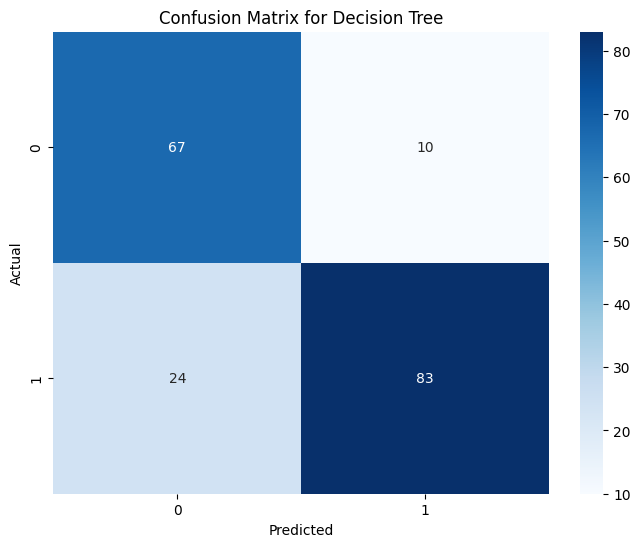

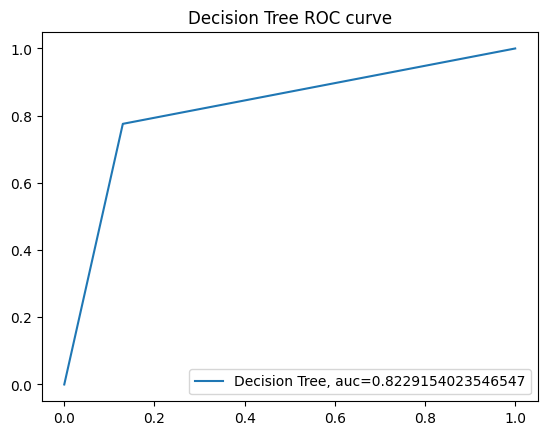

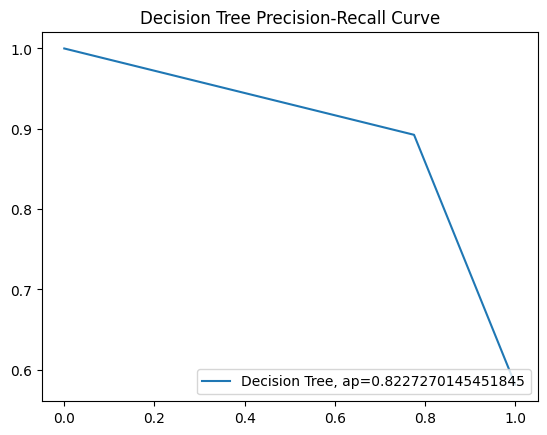

In [ ]:
# fit model
model = DecisionTreeClassifier()

model.fit(X_train, y_train)

# Predict
y_training_pred = model.predict(X_train)
y_pred = model.predict(X_test)

# accuracy
print("Training accuracy: ", accuracy_score(y_training_pred, y_train))
print("Test accuracy: ", accuracy_score(y_pred, y_test))

# classification report
ds_report = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))

#store metrics
ds_accuracy = ds_report['accuracy']
ds_precision = ds_report['weighted avg']['precision']
ds_recall = ds_report['weighted avg']['recall']
ds_f1 = ds_report['weighted avg']['f1-score']
print(y_pred)

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Decision Tree')
plt.show()

# roc curve
probs = model.predict_proba(X_test)
y_pred_proba = probs[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="Decision Tree, auc="+str(auc))
plt.title('Decision Tree ROC curve')
plt.legend(loc=4)
plt.show()

# precision recall
precision, recall, thresholds = precision_recall_curve(y_test,  y_pred_proba)
ap=metrics.average_precision_score(y_test, y_pred_proba)
plt.plot(recall,precision,label="Decision Tree, ap="+str(ap))
plt.title('Decision Tree Precision-Recall Curve')
plt.legend(loc=4)
plt.show()

#store metrics
ds_auc = auc
ds_ap = ap

##MODEL 5: MLP##

In [ ]:
# define MLP
model = Sequential([
  Dense(64, activation='relu', input_dim=X_train.shape[1]),
  Dropout(0.2),
  Dense(32, activation='relu'),
  Dropout(0.2),
  Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# fit model - hyperparameters were just chosen as those commonly used
model.fit(X_train, y_train, epochs=20, batch_size=32)

# predict on test set
y_pred_proba = model.predict(X_test)
y_pred= [1 if p > 0.5 else 0 for p in y_pred_proba]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5250 - loss: 0.6945
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7512 - loss: 0.5418 
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7500 - loss: 0.5349 
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8134 - loss: 0.4317 
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8112 - loss: 0.4208 
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8106 - loss: 0.4136 
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8655 - loss: 0.3711 
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8375 - loss: 0.3980 
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8496 - loss: 0.3675 
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8706 - loss: 0.3593 
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8375 - loss: 0.3675 
Epoch 12/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0

Test accuracy:  0.8641304347826086
              precision    recall  f1-score   support

           0       0.82      0.86      0.84        77
           1       0.89      0.87      0.88       107

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.87      0.86      0.86       184

[0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1]


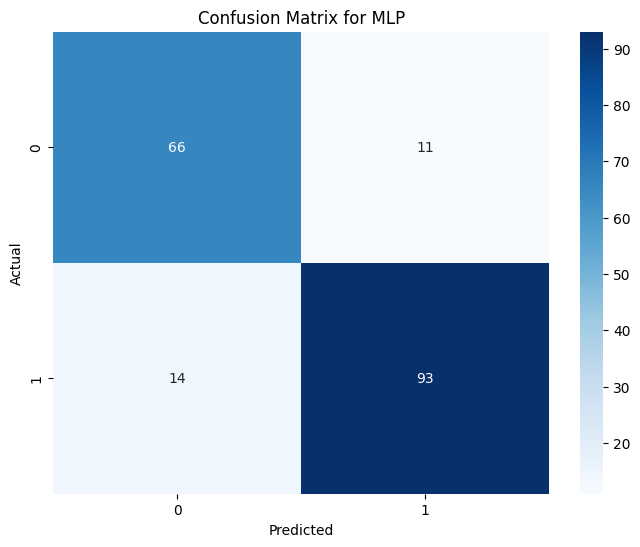

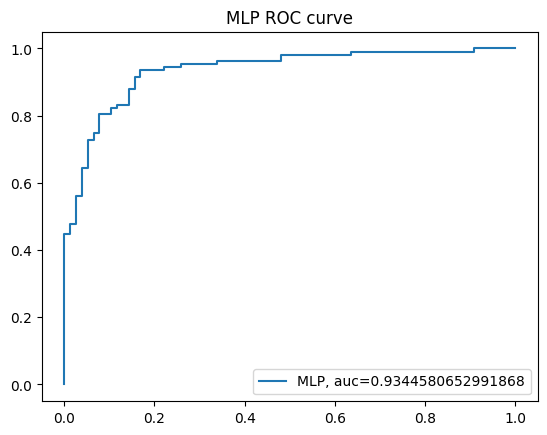

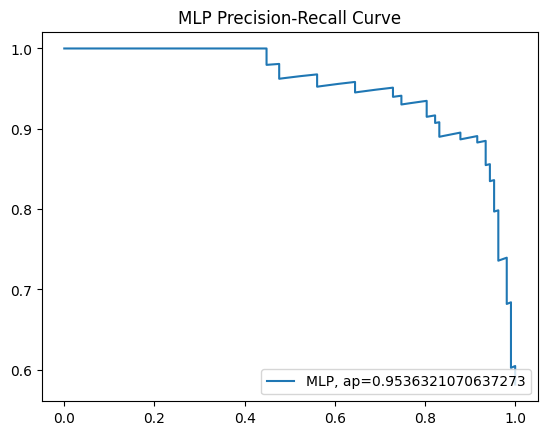

In [ ]:
# Accuracy
print("Test accuracy: ", accuracy_score(y_pred, y_test))

#classification report
mlp_report = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))

#store metrics
mlp_accuracy = mlp_report['accuracy']
mlp_precision = mlp_report['weighted avg']['precision']
mlp_recall = mlp_report['weighted avg']['recall']
mlp_f1 = mlp_report['weighted avg']['f1-score']
print(y_pred)

#Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for MLP')
plt.show()

#roc
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="MLP, auc="+str(auc))
plt.title('MLP ROC curve')
plt.legend(loc=4)
plt.show()

#precision recall
precision, recall, thresholds = precision_recall_curve(y_test,  y_pred_proba)
ap=metrics.average_precision_score(y_test, y_pred_proba)
plt.plot(recall,precision,label="MLP, ap="+str(ap))
plt.title('MLP Precision-Recall Curve')
plt.legend(loc=4)
plt.show()

# store metrics
mlp_auc = auc
mlp_ap = ap

##MODEL 6: SUPPORT VECTOR CLASSIFIER##

In [ ]:
# fit model
svc_model = SVC(kernel='linear', probability = True)
svc_model.fit(X_train, y_train)

# predict
y_pred_proba = svc_model.predict(X_test)
y_pred= [1 if p > 0.5 else 0 for p in y_pred_proba]

Test accuracy:  0.8586956521739131
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        77
           1       0.90      0.85      0.88       107

    accuracy                           0.86       184
   macro avg       0.85      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184

[0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1]


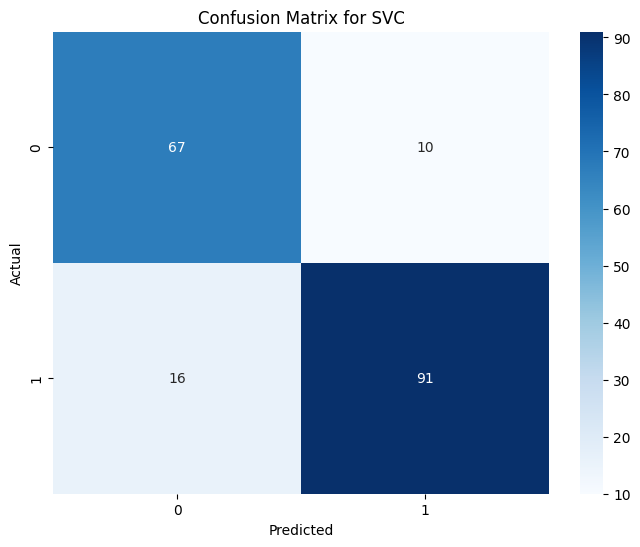

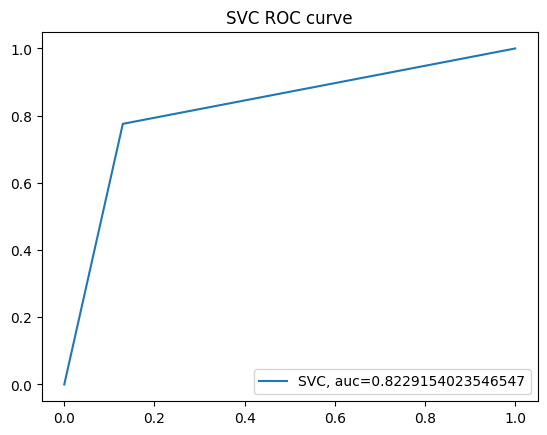

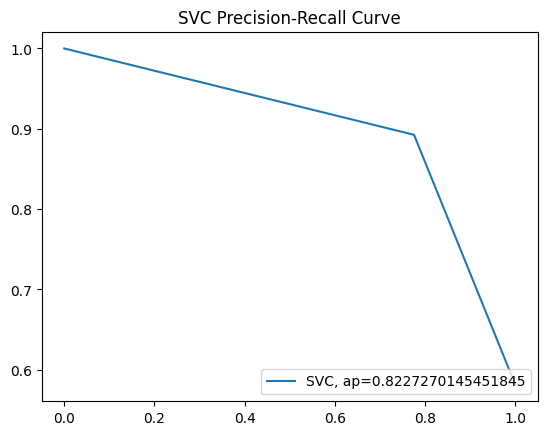

In [ ]:
# accuracy
print("Test accuracy: ", accuracy_score(y_pred, y_test))

#classification report
svc_report = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))

#store metrics
svc_accuracy = svc_report['accuracy']
svc_precision = svc_report['weighted avg']['precision']
svc_recall = svc_report['weighted avg']['recall']
svc_f1 = svc_report['weighted avg']['f1-score']
print(y_pred)

#confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for SVC')
plt.show()


#roc curve
y_pred_proba = probs[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="SVC, auc="+str(auc))
plt.title('SVC ROC curve')
plt.legend(loc=4)
plt.show()

#precision recall
precision, recall, thresholds = precision_recall_curve(y_test,  y_pred_proba)
ap=metrics.average_precision_score(y_test, y_pred_proba)
plt.plot(recall,precision,label="SVC, ap="+str(ap))
plt.title('SVC Precision-Recall Curve')
plt.legend(loc=4)
plt.show()

#store metrics
svc_auc = auc
svc_ap = ap

In [ ]:

# dict to store the metrics
data = {
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'Decision Tree', 'MLP', 'SVC'],
    'Accuracy': [logistic_accuracy, rf_accuracy, xg_accuracy, ds_accuracy, mlp_accuracy, svc_accuracy],
    'Recall': [logistic_recall, rf_recall, xg_recall, ds_recall, mlp_recall, svc_recall],
    'Precision': [logistic_precision, rf_precision, xg_precision, ds_precision, mlp_precision, svc_precision],
    'F1 Score': [logistic_f1, rf_f1, xg_f1, ds_f1, mlp_f1, svc_f1],
    'AUC': [logisitc_auc, rf_auc, xg_auc, ds_auc, mlp_auc, svc_auc],
    'AP': [logistic_ap, rf_ap, xg_ap, ds_ap, mlp_ap, svc_ap]
}


df = pd.DataFrame(data)
print(round(df,3))

                 Model  Accuracy  Recall  Precision  F1 Score    AUC     AP
0  Logistic Regression     0.870   0.870      0.873     0.870  0.928  0.950
1        Random Forest     0.902   0.902      0.904     0.902  0.945  0.960
2              XGBoost     0.870   0.870      0.870     0.870  0.935  0.955
3        Decision Tree     0.815   0.815      0.827     0.816  0.823  0.823
4                  MLP     0.864   0.864      0.865     0.864  0.934  0.954
5                  SVC     0.859   0.859      0.862     0.859  0.823  0.823
